<h1 align=center> Neural Networks - Basic ANN Class </h1>

<hr>

### Introduction

In this notebook I will build an **Artificial Neural Network class** that will have basic functionality and will implement a **batch gradient descend** for training. The class will support **two hyperparameters**: the number of neurons, and the optional use of bias.

I will try the class first with the toy dataset remebling the **MNIST** handwritten digit dataset, and finally with the first instances of MNIST. Later on I will **build over this class** to add some features that will allow me to train the network over the complete MNIST data set, such as **mini-batch gradient descend**, **learning step** and **regularization**.

In [1]:
import numpy as np

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=False)

import struct
import os
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # to hide the exp overflow warnings in the training.

In [2]:
# uncomment this line in case you want to reproduce the results and plotly is not installed
#!pip install plotly

In [3]:
class ANN(object):
    ''' 
    Artificial Network Class. 
    '''
    
    def __init__(self, X, y, bias=True, n_neurons=5, random_seed=0, verbose=True):
        '''
        Parameters:
            X: Data to train the model 
               Instances as rows and features as columns
            y: Desired output of the network
            
            bias: True to use bias in the input and in the hidden layer
            n_neurons: number of neurons in the hidden layer
            verbose: True to output feedback when training
            random_seed: to control the reproducibility.
        '''
        
                # initialize basic parameters of the ANN:
        self.bias = bias
        self.X = X
        self.y = y
        if bias:
            self.X = self._add_bias(self.X)        # add an extra column if needed
        
        self.n_inputs = self.X.shape[0]            # number of inputs (rows)
        self.n_features = self.X.shape[1]          # number of features (columns)
        self.n_outputs = self.y.shape[1]           # number of rows in the output
        self.n_neurons = n_neurons                 # number of neurons in the hidden layer

        self.random_seed = random_seed             # controls the reproducibility 
        self.verbose = verbose                     # controls the feedback durng training
        self.train_step = 0 
        
        self.costs = [0]                           # store the cost function at each step 
        self._init_weights()                       # initialize the weights of the neurons
                
            
            
    # ---------     Main Logic Methods   --------------- #

    def _forward(self):
        '''
        This method contains the main algorithm 
        for feeding the network (feed forward)  
        '''
        self.z2 = np.dot(self.X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        
        if self.bias:
            self.a2 = self._add_bias(self.a2)
    
        self.z3 = np.dot(self.a2, self.W2)
        self.a3 = self.sigmoid(self.z3)
    
    
    def _backwards(self):
        '''
        This method contains the main algorithm 
        for training the network (back propagation) 
        '''
        self.e3 = self.y - self.a3
        self.d3 = self.e3*self.sigmoid_prime(self.a3)

        self.e2 = np.dot(self.d3, self.W2.T)
        self.d2 = self.e2 * self.sigmoid_prime(self.a2)

        self.D2 = np.dot(self.a2.T, self.d3)
        self.D1 = np.dot(self.X.T, self.d2)
        
        if self.bias:
            self.D1 = self.D1[:,1:] # remove the extra bias column
            
            
    def _update_weights(self):
        '''update W1 and W2 with their Deltas'''
        self.W1 += self.D1
        self.W2 += self.D2

        
    def _compute_cost(self):
        '''Compute the cost function using the predicted value (a3) and the target (y)'''
        self.last_cost = (sum((ann.a3 - ann.y)**2)*0.5)[0]
        
        
    def _update_cost(self):
        '''update the cost of the network'''
        self._compute_cost()
        self.costs.append(self.last_cost)
        
        
        
    # --------- Functional Methods ----------- #
    
    def train_once(self):
        '''Train the network a single time'''
        self._forward()
        self._backwards()
        self._update_weights()
        
        self._update_cost()
        self.train_step += 1
            
    def train(self, train_steps=10000):
        '''Wrap to carry one training routine, controling the epochs (steps)'''
        for _ in range(train_steps):
            self.train_once()
            if self.verbose and not self.train_step%int(train_steps/5):
                print("iteration: {}, cost: {:.3E}".format(self.train_step, self.costs[-1]))
    
        
    def plot_costs(self):
        '''Plot the costs of the training process'''
        data = [{"x":list(range(len(self.costs))), "y": self.costs}]
        layout = go.Layout(title="Cost Function evolution", 
                           xaxis=dict(title="Epoch (training steps)"), 
                           yaxis=dict(title="Cost"))
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)
    
    
    # --------    Helper methods   ------------------------ #
        
    def sigmoid(self, t):
        '''Sigmoid function'''
        return 1/(1+np.exp(-t))

    def sigmoid_prime(self, t):
        '''Derivate of sigmoid function'''
        return self.sigmoid(t)*(1 - self.sigmoid(t))
    
    def _add_bias(self, A, axis=1):
        '''append a bias column to a given matrix A'''
        bias = np.ones(len(A)).reshape(len(A), 1)
        return np.append(bias, A, axis=axis)
    
    def _init_weights(self):
        '''initilize the weights W1 and W2'''
        
        np.random.seed(self.random_seed) # to produce reproducible results
        
        self.W1 = np.random.random((self.n_features, self.n_neurons))

        b = 1 if self.bias else 0 # add an extra input in the hidden layer when using bias
        self.W2 = np.random.random((self.n_neurons + b, self.n_outputs))

    

Let's try first with the known xor example to see that everything is in place:

# Examples

## XOR network

In [4]:
def print_logic_table(X, outputs):
    '''given an input matrix X with x and y features, 
    and a list of outputs, prints the corresponding logic table.
    The format of outputs is [{"O": [y1, y2, y3, y4], "tag": OP_name}]'''

    header = "_ X _ Y __"
    row_structure = "| {} | {} ||"
    
    for output in outputs:
        header += " {} _".format(output["tag"])
        row_structure += "  {}  |"
        
    print(header)
    for i, row in enumerate(X):
        
        x, y = int(row[0]), int(row[1])
        output_row = [output["O"][i] for output in outputs]
        
        format_items = [x, y] + output_row
        
        print(row_structure.format(*format_items))

In [5]:
X_logic = np.array([[1,0,1,0], [1,1,0,0]]).T
y_xor = np.array([[0,1,1,0]]).T

With bias...

In [6]:
ann = ANN(X_logic, y_xor, n_neurons=8)
ann.train(5000)
print_logic_table(X_logic, [{"tag": "XOR", "O": [0,1,1,0]}, 
                            {"tag": "XOR (ANN)", "O": ["{:.3E}".format(y) for y in ann.a3.flatten()]}])
ann.plot_costs()

iteration: 1000, cost: 4.143E-01
iteration: 2000, cost: 1.219E-02
iteration: 3000, cost: 2.302E-03
iteration: 4000, cost: 8.991E-04
iteration: 5000, cost: 4.595E-04
_ X _ Y __ XOR _ XOR (ANN) _
| 1 | 1 ||  0  |  1.411E-02  |
| 0 | 1 ||  1  |  9.830E-01  |
| 1 | 0 ||  1  |  9.833E-01  |
| 0 | 0 ||  0  |  1.236E-02  |


And without bias...

In [7]:
ann = ANN(X_logic, y_xor, n_neurons=8, bias=False)
ann.train(5000)
print_logic_table(X_logic, [{"tag": "XOR", "O": [0,1,1,0]}, 
                            {"tag": "XOR (ANN)", "O": ["{:.3E}".format(y) for y in ann.a3.flatten()]}])
ann.plot_costs()

iteration: 1000, cost: 4.771E-01
iteration: 2000, cost: 2.107E-02
iteration: 3000, cost: 3.445E-03
iteration: 4000, cost: 1.352E-03
iteration: 5000, cost: 7.174E-04
_ X _ Y __ XOR _ XOR (ANN) _
| 1 | 1 ||  0  |  1.740E-02  |
| 0 | 1 ||  1  |  9.790E-01  |
| 1 | 0 ||  1  |  9.788E-01  |
| 0 | 0 ||  0  |  1.549E-02  |


## MNIST resembling toy data set

Note: This data set has been taken from the book *Data Science from Scratch* by **Joel Grus**, from the chapter 18 on Neural Networks.

I find it very convenient to use given the resemblance with the MNIST problem, particularly, the 10 classes output and the 'image' input.

In [8]:
d0 = [1,1,1,1,1,
      1,0,0,0,1,
      1,0,0,0,1,
      1,0,0,0,1,
      1,1,1,1,1]

d1 = [0,0,1,0,0,
      0,0,1,0,0,
      0,0,1,0,0,
      0,0,1,0,0,
      0,0,1,0,0]

d2 = [1,1,1,1,1,
      0,0,0,0,1,
      1,1,1,1,1,
      1,0,0,0,0,
      1,1,1,1,1]

d3 = [1,1,1,1,1,
      0,0,0,0,1,
      1,1,1,1,1,
      0,0,0,0,1,
      1,1,1,1,1]

d4 = [1,0,0,0,1,
      1,0,0,0,1,
      1,1,1,1,1,
      0,0,0,0,1,
      0,0,0,0,1]

d5 = [1,1,1,1,1,
      1,0,0,0,0,
      1,1,1,1,1,
      0,0,0,0,1,
      1,1,1,1,1]

d6 = [1,1,1,1,1,
      1,0,0,0,0,
      1,1,1,1,1,
      1,0,0,0,1,
      1,1,1,1,1]

d7 = [1,1,1,1,1,
      0,0,0,0,1,
      0,0,0,0,1,
      0,0,0,0,1,
      0,0,0,0,1]

d8 = [1,1,1,1,1,
      1,0,0,0,1,
      1,1,1,1,1,
      1,0,0,0,1,
      1,1,1,1,1]

d9 = [1,1,1,1,1,
      1,0,0,0,1,
      1,1,1,1,1,
      0,0,0,0,1,
      0,0,0,0,1]

digits_inputs = np.array([d0, d1, d2, d3, d4, d5, d6, d7, d8, d9])

We need to handle the problem as a 10 classes classification problem, which each class can be understood as the *probability* of being that number.

In [9]:
digits_targets = np.identity(10)
digits_targets

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [25]:
ann = ANN(digits_inputs, digits_targets, n_neurons=20)
ann.train(200)
ann.plot_costs()

iteration: 40, cost: 3.080E-01
iteration: 80, cost: 2.440E-01
iteration: 120, cost: 1.100E-01
iteration: 160, cost: 1.829E-02
iteration: 200, cost: 8.622E-03


Let's see what is the output of the network. We need a helper class to return the index of the maximum element of each row.

In [11]:
def get_max(row):
    return max(range(len(row)), key=row.__getitem__)

Let's also examine in detail the outputs and what is the probability distribution for each of them:

In [26]:
bars = [go.Bar(x=list(range(10)), y=[ann.a3[j][i] for j in range(10)], 
               name="{} class".format(i)) for i in range(10)]

layout = go.Layout(
    title="ANN digit toy dataset output",
    barmode='stack',
    xaxis=dict(autotick=False, title="Output"),
    yaxis=dict(title="value"),
)

fig = go.Figure(data=bars, layout=layout)
iplot(fig)

As we can see, all the ouputs produce the maximum value for the correct number. It is interesting to see how the classes 8 and 3 are the ones that appear in more outputs, very likely because of the resemblance of the 8, 3 and other numbers such as 5. We can see in the graph what numbers the ANN finds similar. 

Although it is tempting to take the output as a probability of being that number, we can see here that it is not correct because the values are not normalized and they do not sum up 1. 

In any case, we can see that the correct value is computed for every case:

In [16]:
[get_max(a3) for a3 in ann.a3]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<br><br>
## MNIST data set - First contact

### Data loading and inspection

In [17]:
# labels
with open("data/train-labels-idx1-ubyte", "rb") as labels_file:
    struct.unpack(">II", labels_file.read(8))
    labels = np.fromfile(labels_file, dtype=np.int8)

# Images
with open("data/train-images-idx3-ubyte", 'rb') as imgs_file:
    _, _, rows, cols = struct.unpack(">IIII", imgs_file.read(16))
    images = np.fromfile(imgs_file, dtype=np.uint8).reshape(len(labels), rows, cols)

In [18]:
def print_image(index, ax, images=images, labels=labels):
    '''helper function to plot an image together with its label'''
    ax.matshow(images[index], cmap="Greys")
    ax.set_title("Label: {}".format(labels[index]), fontsize=8)
    ax.axis("off");

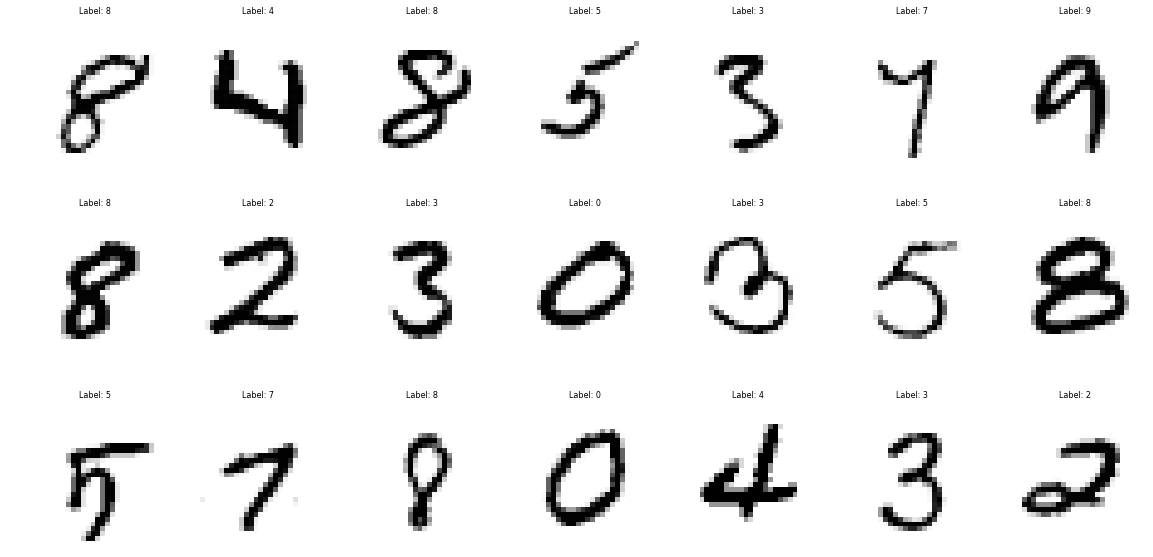

In [19]:
n_rows, n_cols = 3, 7
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,10))

n_imgs = len(labels)
for row in range(n_rows):
    for col in range(n_cols):
        i = np.random.randint(n_imgs)
        print_image(i, ax=axs[row, col])


<br><br><br>
### Data transformation

In order to train the model we first need to transform the data a little bit. We need to normalize the input (so the value of each pixel ranges from 0 to 1) and format the taget as a 10 class classification problem.

In [20]:
def expand_label(label):
    new_label = np.zeros(10)
    new_label[label] = 1
    return new_label

Let's try with 500 images and 50 neurons

In [21]:
n_train = 500
offset_train = 0

train_X = images[offset_train:offset_train+n_train]
train_X = np.array([i.flatten() for i in train_X])
train_X = np.array([img / max(img) for img in train_X]) # normalize

train_y = labels[offset_train:offset_train+n_train]
train_y = np.array([train_y]).T
train_y = np.array([expand_label(y) for y in train_y])

ann = ANN(X=train_X, y=train_y, n_neurons=50)
ann.train(10000)
ann.plot_costs()

iteration: 2000, cost: 1.852E+02
iteration: 4000, cost: 1.213E+02
iteration: 6000, cost: 5.899E+00
iteration: 8000, cost: 1.733E+01
iteration: 10000, cost: 1.533E+01


As we can see, the network is having big troubles to converge to a low enough value of the cost function. After adding more neurons and not seeing any improvement, let's try with 100 images before jumping into conclusions.

In [22]:
n_train = 100
offset_train = 0

train_X = images[offset_train:offset_train+n_train]
train_X = np.array([i.flatten() for i in train_X])
train_X = np.array([img / max(img) for img in train_X]) # normalize

train_y = labels[offset_train:offset_train+n_train]
train_y = np.array([train_y]).T
train_y = np.array([expand_label(y) for y in train_y])

ann = ANN(X=train_X, y=train_y, n_neurons=50)
ann.train(10000)
ann.plot_costs()

iteration: 2000, cost: 3.495E+00
iteration: 4000, cost: 1.367E-05
iteration: 6000, cost: 1.199E-06
iteration: 8000, cost: 4.964E-07
iteration: 10000, cost: 2.954E-07


Now the result is much better. The network converges before 4000 epochs.

Below are some of the changes we could implement:

Very likely the **learning step is too large**. We need to scale down the $\Delta$ values (D1 and D2) before upgrading the weights (W1 and W2) at each interaction.

Right now I'm using a **Batch gradient descent**, this is, each of the weights is calculated at once and changed all together at the end of the interaction *in one single batch*. Because 100 inputs produced a much better result than 500 inputs (when we usually would like more data to get better results), maybe adapting the weight upgrading in such a way that is done in batches (100 inputs at a time, for instance) the result is much better. This is a **mini-batch gradient descend** approach.

Although I'm not comparing my model against the rest of the data set (using a train-test approach), we can already implement a **regularization** feature to avoid **overfitting** (for the model to penalize big changes in the individual weights and prevent memorizing them).

Finally, it would be nice to have some extra features such as a **predicting function**, so it is easy to feed_forward data outside the model to produce outputs. This way we can **score the model**. This is crucial if we want to **tune the hyperparameters**. 

<br><br><br><br><br><br><br>